# Import Libraries

In [1]:
!pip install gdown

In [1]:
!gdown --id 1dQtjVf_T0gH8SXjXGVItyRTYGgXtAU-t

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1dQtjVf_T0gH8SXjXGVItyRTYGgXtAU-t
From (redirected): https://drive.google.com/uc?id=1dQtjVf_T0gH8SXjXGVItyRTYGgXtAU-t&confirm=t&uuid=0a54a67a-33d9-4490-b1d3-abc1637d0286
To: /kaggle/working/SMAI_Test_Videos.zip
100%|██████████████████████████████████████| 46.4M/46.4M [00:01<00:00, 40.7MB/s]


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import logging
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

2025-05-06 17:00:26.696174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746550826.949349      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746550827.020770      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Setup logging
logging.basicConfig(filename='lrcn_training_log.txt', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

### FEATURE EXTRACTION CODE

In [ ]:
import os
import cv2
import numpy as np
import torch
from torchvision import transforms, models
import torch.nn as nn
from PIL import Image

# Mount Google Drive if using Colab
from google.colab import drive
drive.mount('/content/drive')

# Global constants for frame extraction and feature extraction
FRAME_HEIGHT = 224
FRAME_WIDTH = 224
NUM_FRAMES = 40
BATCH_SIZE = 16

# Define image transformation (used for frame extraction)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((FRAME_HEIGHT, FRAME_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def extract_frames(video_path, num_frames=NUM_FRAMES):
    """
    Extract frames from a video.
    If the video has fewer frames than num_frames, duplicate the last frame.
    Returns:
      frames: Tensor of shape (num_frames, 3, FRAME_HEIGHT, FRAME_WIDTH)
      sequence_length: actual number of frames extracted before padding
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if frame_count <= num_frames:
        indices = list(range(frame_count))
    else:
        indices = np.linspace(0, frame_count - 1, num_frames, dtype=int)

    for i in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            # Convert BGR to RGB and transform
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = transform(frame)
            frames.append(frame)

    cap.release()
    sequence_length = len(frames)

    # Pad if not enough frames
    while len(frames) < num_frames:
        frames.append(frames[-1] if frames else torch.zeros(3, FRAME_HEIGHT, FRAME_WIDTH))

    frames = frames[:num_frames]
    return torch.stack(frames), sequence_length

def extract_features(frames, batch_size=BATCH_SIZE):
    """
    Extract features from frames using a pretrained ResNet50 (without its final layer).
    Returns:
      features: Tensor of shape (num_frames, 2048)
    """
    # Load pretrained ResNet50 and remove classification head
    feature_extractor = models.resnet50(pretrained=True)
    feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-1])
    feature_extractor.eval().to(device)

    features = []
    with torch.no_grad():
        for i in range(0, len(frames), batch_size):
            batch = frames[i:i+batch_size].to(device)
            batch_features = feature_extractor(batch)
            # Squeeze out spatial dimensions: (batch, 2048, 1, 1) -> (batch, 2048)
            batch_features = batch_features.squeeze(-1).squeeze(-1)
            features.append(batch_features.cpu())

    return torch.cat(features, dim=0)

def extract_and_save_features(video_path, output_dir):
    """
    For a given video, extract frames and then features.
    Save the features and sequence_length as a dictionary to a .pt file.
    """
    os.makedirs(output_dir, exist_ok=True)
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    frames, seq_len = extract_frames(video_path)
    features = extract_features(frames)

    save_dict = {
        'features': features,  # shape: (NUM_FRAMES, 2048)
        'seq_len': seq_len
    }
    save_path = os.path.join(output_dir, f"{video_name}_features.pt")
    torch.save(save_dict, save_path)
    print(f"Saved features for {video_name} to {save_path}")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define paths for training videos and for saving features
# Folder structure: /content/drive/MyDrive/CricShot10 dataset/<class_name>/*.avi
train_video_dir = "/content/drive/MyDrive/CricShot10 dataset"
features_train_dir = "/content/drive/MyDrive/cricket_features/train"

# Define class labels (must match your subfolder names exactly)
CLASS_LABELS = ['cover', 'defense', 'flick', 'hook', 'late_cut',
                'lofted', 'pull', 'square_cut', 'straight', 'sweep']

def load_dataset(video_dir):
    """
    Loads video paths and labels based on folder structure.
    Returns:
      video_paths: list of video file paths
      labels: corresponding list of label indices
    """
    video_paths = []
    labels = []
    for class_idx, class_name in enumerate(CLASS_LABELS):
        class_folder = os.path.join(video_dir, class_name)
        if not os.path.exists(class_folder):
            print(f"Warning: folder {class_folder} does not exist.")
            continue
        for file_name in os.listdir(class_folder):
            if file_name.endswith(('.avi', '.mp4')):
                full_path = os.path.join(class_folder, file_name)
                video_paths.append(full_path)
                labels.append(class_idx)
    return video_paths, labels

# Load training video paths and labels
train_video_paths, train_labels = load_dataset(train_video_dir)
print(f"Found {len(train_video_paths)} training videos.")

# Loop over training videos and save features
# for video_path in train_video_paths:
#     extract_and_save_features(video_path, features_train_dir)

In [5]:
# Dataset Class
class CricketDataset(Dataset):
    def __init__(self, features_dir, video_names, labels, augment=False):
        self.features_dir = features_dir
        self.video_names = video_names
        self.labels = labels
        self.augment = augment
        
        # Log dataset stats
        seq_lens = []
        for name in video_names:
            data = torch.load(os.path.join(self.features_dir, f"{name}_features.pt"), map_location=device, weights_only=True)
            seq_len = data['seq_len']
            seq_lens.append(seq_len)
            if seq_len < 10:
                logging.warning(f"Short sequence for {name}: seq_len={seq_len}")
        
        class_counts = Counter(labels)
        logging.info(f"Dataset: {len(video_names)} videos, mean seq_len: {np.mean(seq_lens):.2f}, "
                     f"class distribution: {class_counts}")
        
        for cls, count in class_counts.items():
            if count < 20:
                logging.warning(f"Low sample count for class {cls}: {count} videos")
    
    def __len__(self):
        return len(self.video_names)
    
    def __getitem__(self, idx):
        video_name = self.video_names[idx]
        features_path = os.path.join(self.features_dir, f"{video_name}_features.pt")
        data = torch.load(features_path,map_location=device, weights_only=True)
        features = data['features']
        seq_len = data['seq_len']
        label = self.labels[idx]
        
        # Feature-level augmentation
        if self.augment:
            # Apply noise
            if torch.rand(1) < 0.8:
                noise_level = torch.rand(1).item() * 0.15
                noise = torch.randn_like(features) * noise_level
                features = features + noise
            
            # Randomly drop frames
            if torch.rand(1) < 0.3 and seq_len > 5:
                drop_idx = torch.randperm(seq_len)[:int(seq_len * 0.1)]
                mask = torch.ones_like(features[:seq_len])
                for i in drop_idx:
                    mask[i] = 0
                features[:seq_len] = features[:seq_len] * mask
            
            # Feature masking
            if torch.rand(1) < 0.3:
                mask_size = int(features.shape[1] * 0.1)
                start = torch.randint(0, features.shape[1] - mask_size, (1,)).item()
                features[:, start:start+mask_size] = 0
                
        return features, seq_len, label

# Store extracted features

In [4]:
# Collate Function
def collate_fn(batch):
    features, seq_lens, labels = zip(*batch)
    features = torch.stack(features)
    seq_lens = torch.tensor(seq_lens)
    labels = torch.tensor(labels)
    return features, seq_lens, labels

# Model Architecture

In [5]:
# Model Definition with Attention Mechanism
class CricketShotClassifier(nn.Module):
    def __init__(self, input_size=2048, hidden_size=256, num_layers=2, num_classes=10, dropout=0.5):
        super(CricketShotClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, 
                           bidirectional=True,
                           dropout=dropout if num_layers > 1 else 0)
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, 128),  # *2 for bidirectional
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        self.fc = nn.Sequential(
            nn.BatchNorm1d(hidden_size * 2),  # *2 for bidirectional
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x, seq_lens):
        # Sort by sequence length for packed sequence
        sort_idx = torch.argsort(seq_lens, descending=True)
        x_sorted = x[sort_idx]
        seq_lens_sorted = seq_lens[sort_idx]
        
        # Pack, run LSTM, and unpack
        packed_x = rnn_utils.pack_padded_sequence(x_sorted, seq_lens_sorted.cpu(), batch_first=True, enforce_sorted=True)
        packed_out, (hidden, _) = self.lstm(packed_x)
        output, _ = rnn_utils.pad_packed_sequence(packed_out, batch_first=True)
        
        # Apply attention
        batch_size = output.size(0)
        weighted_outputs = []
        
        for i in range(batch_size):
            seq_len = seq_lens_sorted[i]
            attention_score = self.attention(output[i, :seq_len]).squeeze(-1)
            attention_score = torch.softmax(attention_score, dim=0)
            weighted_output = torch.matmul(attention_score.unsqueeze(0), output[i, :seq_len])
            weighted_outputs.append(weighted_output)
        
        # Concatenate outputs
        out = torch.cat(weighted_outputs, dim=0)
        
        # Unsort
        unsort_idx = torch.argsort(sort_idx)
        out = out[unsort_idx]
        
        # Final classification
        out = self.fc(out)
        return out

# Visulaize Training

In [6]:
# Visualizations Setup
class TrainingVisualizer:
    def __init__(self, save_dir='plots'):
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []
        self.lr_history = []
        self.cm_data = None
        self.class_names = None
    
    def update(self, epoch, train_loss, val_loss, train_acc, val_acc, lr, cm=None, class_names=None):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.train_accs.append(train_acc)
        self.val_accs.append(val_acc)
        self.lr_history.append(lr)
        
        if cm is not None:
            self.cm_data = cm
            self.class_names = class_names
        
        # Save plots after each update
        self.plot_metrics()
        if self.cm_data is not None:
            self.plot_confusion_matrix()
    
    def plot_metrics(self):
        # Create figure with 2 subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Training Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accs, label='Training Accuracy')
        ax2.plot(self.val_accs, label='Validation Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'training_metrics.png'))
        plt.close()
        
        # Plot learning rate
        plt.figure(figsize=(10, 5))
        plt.plot(self.lr_history)
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.grid(True)
        plt.savefig(os.path.join(self.save_dir, 'learning_rate.png'))
        plt.close()
    
    def plot_confusion_matrix(self):
        if self.cm_data is None:
            return
            
        plt.figure(figsize=(12, 10))
        sns.heatmap(self.cm_data, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.class_names,
                    yticklabels=self.class_names)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'confusion_matrix.png'))
        plt.close()

# Model Traning

In [9]:
# Training Function
def train_model(model, train_loader, val_loader, class_names, num_epochs=50, patience=7):
    model = model.to(device)
    
    # Setup tensorboard and visualizer
    writer = SummaryWriter('cricket_logs')
    visualizer = TrainingVisualizer()
    
    # Class weighting for imbalanced classes
    class_counts = Counter(train_loader.dataset.labels)
    total_samples = sum(class_counts.values())
    class_weights = torch.tensor([total_samples / (len(class_counts) * class_counts[i]) 
                                for i in range(len(class_counts))]).to(device)
    
    # Use Focal Loss for better handling of hard examples
    class FocalLoss(nn.Module):
        def __init__(self, weight=None, gamma=2.0, reduction="mean"):
            super(FocalLoss, self).__init__()
            self.weight = weight
            self.gamma = gamma
            self.reduction = reduction
            self.ce = nn.CrossEntropyLoss(weight=weight, reduction="none")
            
        def forward(self, inputs, targets):
            ce_loss = self.ce(inputs, targets)
            pt = torch.exp(-ce_loss)
            focal_loss = ((1 - pt) ** self.gamma) * ce_loss
            
            if self.reduction == "mean":
                return focal_loss.mean()
            elif self.reduction == "sum":
                return focal_loss.sum()
            else:
                return focal_loss
    
    criterion = FocalLoss(weight=class_weights)
    
    # Optimizer with decoupled weight decay
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
    
    # Learning rate scheduling with warmup
    def get_lr_scheduler(optimizer, warmup_epochs=5):
        def lambda_lr(epoch):
            if epoch < warmup_epochs:
                return (epoch + 1) / warmup_epochs
            return 1.0
        
        warmup_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda_lr)
        main_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=4, verbose=True
        )
        
        return warmup_scheduler, main_scheduler
    
    warmup_scheduler, main_scheduler = get_lr_scheduler(optimizer)
    
    best_val_accuracy = 0
    counter = 0
    accum_steps = 4  # Gradient accumulation for stability
    
    # Mixup function for data augmentation
    def mixup_data(x, y, alpha=0.2):
        if alpha > 0:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1
            
        batch_size = x.size()[0]
        index = torch.randperm(batch_size).to(device)
        
        mixed_x = lam * x + (1 - lam) * x[index]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam
    
    def mixup_criterion(criterion, pred, y_a, y_b, lam):
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        optimizer.zero_grad()
        
        # Update LR for warmup period
        if epoch < 5:
            warmup_scheduler.step()
        
        for i, (features, seq_lens, labels) in enumerate(train_loader):
            features, seq_lens, labels = features.to(device), seq_lens.to(device), labels.to(device)
            
            # Initialize lam and labels to default values
            lam = 1.0
            labels_a = labels
            labels_b = labels
            
            # Apply mixup with 50% probability
            use_mixup = np.random.random() < 0.5
            if use_mixup:
                features, labels_a, labels_b, lam = mixup_data(features, labels)
                outputs = model(features, seq_lens)
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            else:
                outputs = model(features, seq_lens)
                loss = criterion(outputs, labels)
            
            loss = loss / accum_steps
            loss.backward()
            
            if (i + 1) % accum_steps == 0:
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()
            
            running_loss += loss.item() * accum_steps
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            
            # Calculate accuracy based on whether we used mixup
            if use_mixup:
                correct_train += (lam * (predicted == labels_a).sum().item() + 
                                (1 - lam) * (predicted == labels_b).sum().item())
            else:
                correct_train += (predicted == labels).sum().item()
        
        train_accuracy = correct_train / total_train
        train_loss = running_loss / len(train_loader)
        
        # Log metrics to tensorboard
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)
        writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], epoch)
        
        logging.info(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                     f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Validation phase
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0
        class_correct = [0] * 10
        class_total = [0] * 10
        
        # For confusion matrix
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for features, seq_lens, labels in val_loader:
                features, seq_lens, labels = features.to(device), seq_lens.to(device), labels.to(device)
                outputs = model(features, seq_lens)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                
                # Store predictions and labels for confusion matrix
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # Per-class accuracy
                for i in range(len(labels)):
                    label = labels[i]
                    class_correct[label] += (predicted[i] == label).item()
                    class_total[label] += 1
        
        val_accuracy = correct_val / total_val
        val_loss = val_loss / len(val_loader)
        
        # Create confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        
        # Update visualizer
        visualizer.update(
            epoch, train_loss, val_loss, train_accuracy, val_accuracy, 
            optimizer.param_groups[0]['lr'], cm, class_names
        )
        
        # Log validation metrics
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/val', val_accuracy, epoch)
        
        # Log per-class accuracy
        for i in range(10):
            if class_total[i] > 0:
                class_acc = class_correct[i] / class_total[i]
                writer.add_scalar(f'Accuracy/class_{i}', class_acc, epoch)
                logging.info(f'Class {i} accuracy: {class_acc:.4f}')
        
        logging.info(f'Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
        
        # Learning rate scheduling based on validation performance
        if epoch >= 5:  # Apply after warmup
            main_scheduler.step(val_accuracy)
        
        # Model checkpointing with early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            counter = 0
            # Save model with timestamp
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': val_accuracy,
                'train_accuracy': train_accuracy,
                'class_names': class_names  # Save class names with the model
            }, 'final_model.pth')
            logging.info("Saved best model at 'best_lrcn_model_1.pth'")
            print("Saved best model at 'best_lrcn_model.pth'")
        else:
            counter += 1
            if counter >= patience:
                logging.info(f"Early stopping at epoch {epoch+1}!")
                print(f"Early stopping at epoch {epoch+1}!")
                break
    
    writer.close()
    return best_val_accuracy

In [12]:
# Main Script
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def main():
    features_train_dir = "/kaggle/input/pytorch-features/cricket_features/train"  # Update to your correct path
    CLASS_LABELS = ['cover', 'defense', 'flick', 'hook', 'late_cut', 'lofted', 'pull', 'square_cut', 'straight', 'sweep']
    
    def load_dataset(features_dir):
        video_names = []
        labels = []
        unmatched_files = []
        for f in os.listdir(features_dir):
            if f.endswith('_features.pt'):
                video_name = f.split('_features.pt')[0]
                found = False
                for idx, class_name in enumerate(CLASS_LABELS):
                    if class_name in video_name.lower():
                        video_names.append(video_name)
                        labels.append(idx)
                        found = True
                        break
                if not found:
                    unmatched_files.append(video_name)
        if unmatched_files:
            logging.warning(f"Unmatched files (skipped): {len(unmatched_files)} files: {unmatched_files[:5]}")
            # Save unmatched files to CSV for manual correction
            pd.DataFrame({'video_name': unmatched_files}).to_csv('unmatched_files.csv', index=False)
            logging.info("Saved unmatched files to 'unmatched_files.csv' for manual labeling")
        if len(video_names) != len(labels):
            raise ValueError("Mismatch between video names and labels")
        if not video_names:
            raise ValueError("No valid feature files found in directory")
        logging.info(f"Loaded {len(video_names)} videos with valid labels")
        return video_names, labels
    
    # Load dataset
    video_names, labels = load_dataset(features_dir=features_train_dir)
    
    # Use K-fold cross-validation for more robust evaluation
    from sklearn.model_selection import KFold
    
    k_folds = 5
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_accuracies = []
    
    # Only do full cross-validation if specified
    do_cross_val = False  # Set to True to enable k-fold cross-validation
    
    if do_cross_val:
        for fold, (train_idx, val_idx) in enumerate(kf.split(video_names)):
            print(f"Starting fold {fold+1}/{k_folds}")
            logging.info(f"Starting fold {fold+1}/{k_folds}")
            
            train_names = [video_names[i] for i in train_idx]
            train_labels = [labels[i] for i in train_idx]
            val_names = [video_names[i] for i in val_idx]
            val_labels = [labels[i] for i in val_idx]
            
            # Create datasets with augmentation for training
            train_dataset = CricketDataset(features_train_dir, train_names, train_labels, augment=True)
            val_dataset = CricketDataset(features_train_dir, val_names, val_labels, augment=False)
            
            # Enhanced balanced sampling
            class_counts = Counter(train_labels)
            total_samples = sum(class_counts.values())
            weights = [total_samples / (len(class_counts) * class_counts[label]) for label in train_labels]
            sampler = WeightedRandomSampler(weights, len(weights))
            
            # Create data loaders
            train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, collate_fn=collate_fn)
            val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
            
            # Create and train model
            model = CricketShotClassifier(input_size=2048, hidden_size=256, num_layers=2, num_classes=10, dropout=0.5)
            fold_acc = train_model(model, train_loader, val_loader, CLASS_LABELS, num_epochs=50, patience=7)
            fold_accuracies.append(fold_acc)
            
            print(f"Fold {fold+1} accuracy: {fold_acc:.4f}")
            logging.info(f"Fold {fold+1} accuracy: {fold_acc:.4f}")
        
        # Report average accuracy across folds
        avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
        print(f"Average accuracy across {k_folds} folds: {avg_accuracy:.4f}")
        logging.info(f"Average accuracy across {k_folds} folds: {avg_accuracy:.4f}")
    else:
        # Simple train/val split
        train_names, val_names, train_labels, val_labels = train_test_split(
            video_names, labels, test_size=0.2, stratify=labels, random_state=42
        )
        
        train_dataset = CricketDataset(features_train_dir, train_names, train_labels, augment=True)
        val_dataset = CricketDataset(features_train_dir, val_names, val_labels, augment=False)
        
        # Enhanced balanced sampling
        class_counts = Counter(train_labels)
        total_samples = sum(class_counts.values())
        weights = [total_samples / (len(class_counts) * class_counts[label]) for label in train_labels]
        sampler = WeightedRandomSampler(weights, len(weights))
        
        train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
        
        model = CricketShotClassifier(input_size=2048, hidden_size=256, num_layers=2, num_classes=10, dropout=0.3)
        best_val_accuracy = train_model(model, train_loader, val_loader, CLASS_LABELS, num_epochs=50, patience=7)
        logging.info(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
        print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1, Train Loss: 1.8932, Train Accuracy: 0.1666, LR: 0.000040
Epoch 1, Val Loss: 1.5783, Val Accuracy: 0.2725
Saved best model at 'best_lrcn_model.pth'
Epoch 2, Train Loss: 1.5086, Train Accuracy: 0.3224, LR: 0.000060
Epoch 2, Val Loss: 1.3352, Val Accuracy: 0.3862
Saved best model at 'best_lrcn_model.pth'
Epoch 3, Train Loss: 1.3311, Train Accuracy: 0.3763, LR: 0.000080
Epoch 3, Val Loss: 1.2106, Val Accuracy: 0.4286
Saved best model at 'best_lrcn_model.pth'
Epoch 4, Train Loss: 1.2457, Train Accuracy: 0.4293, LR: 0.000100
Epoch 4, Val Loss: 1.0876, Val Accuracy: 0.4815
Saved best model at 'best_lrcn_model.pth'
Epoch 5, Train Loss: 1.1330, Train Accuracy: 0.4650, LR: 0.000100
Epoch 5, Val Loss: 1.0113, Val Accuracy: 0.4894
Saved best model at 'best_lrcn_model.pth'
Epoch 6, Train Loss: 0.9160, Train Accuracy: 0.5537, LR: 0.000100
Epoch 6, Val Loss: 0.9263, Val Accuracy: 0.5291
Saved best model at 'best_lrcn_model.pth'
Epoch 7, Train Loss: 0.9900, Train Accuracy: 0.5268, LR: 0.00010

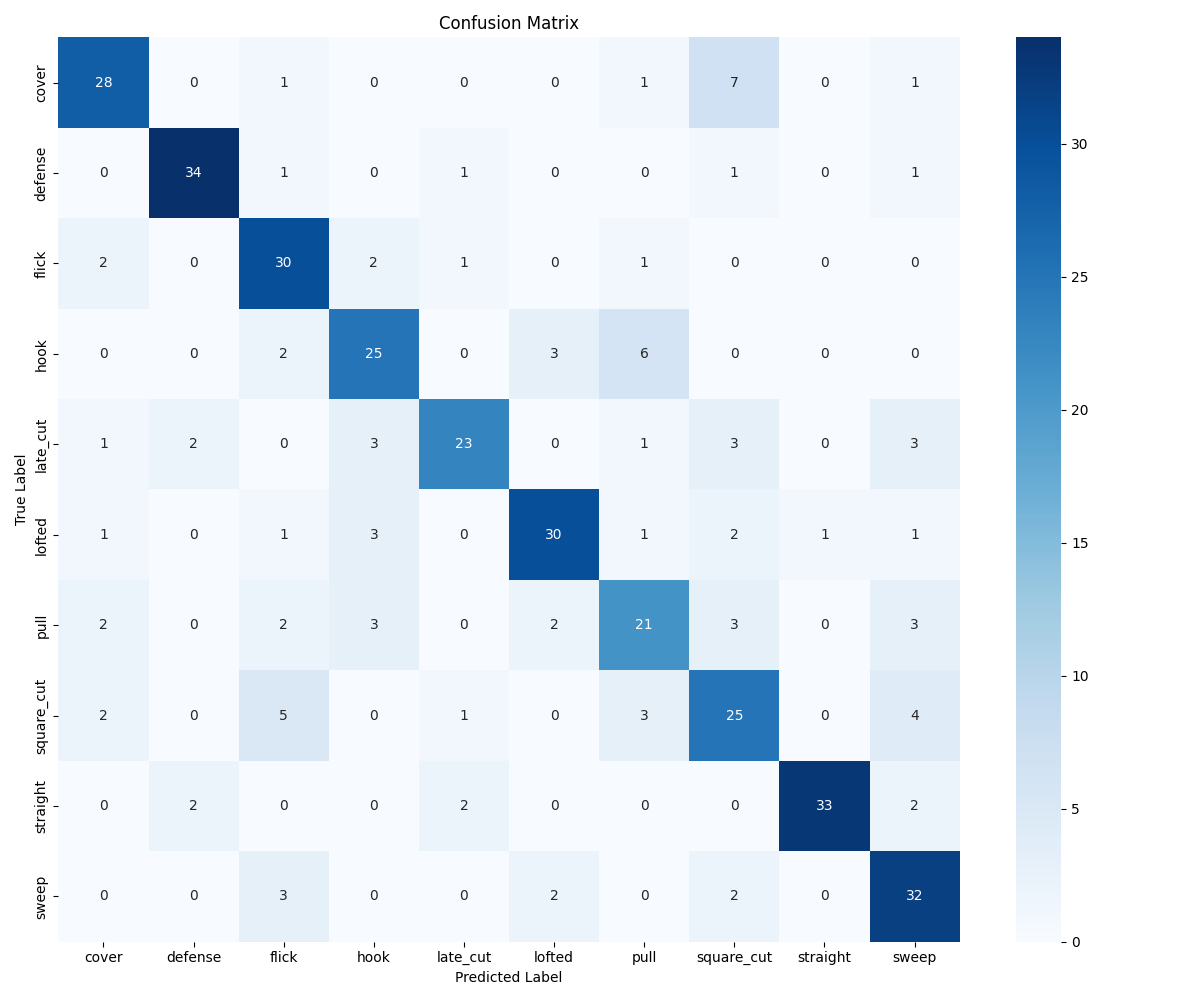

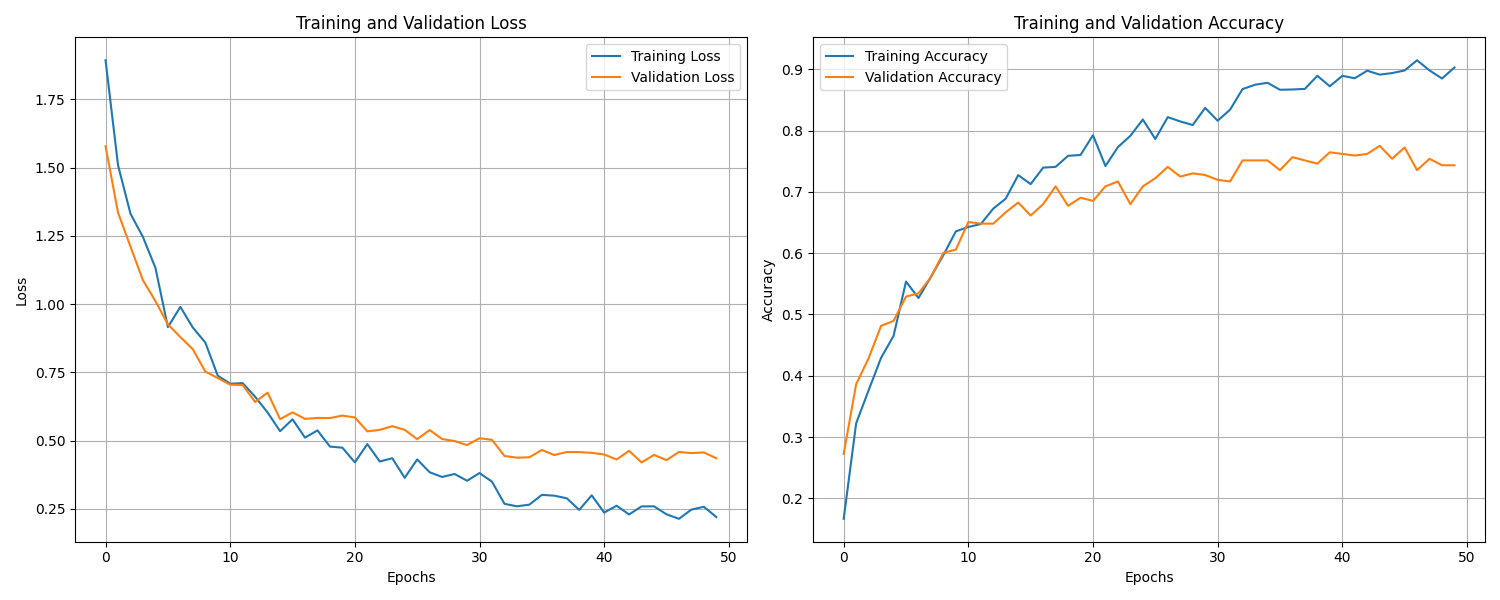

In [14]:
import os
from IPython.display import Image, display

# Define the path to the plots folder
plots_folder = '/kaggle/working/plots'

# Check if the folder exists
if os.path.exists(plots_folder):
    # Loop through all files in the plots folder
    for filename in os.listdir(plots_folder):
        # Check if the file is an image (supports common image extensions)
        if filename == 'confusion_matrix.png' or filename == 'training_metrics.png':
            # Construct the full file path
            file_path = os.path.join(plots_folder, filename)
            # Display the image
            display(Image(filename=file_path))
else:
    print("Plots folder not found in /kaggle/working/")

Downloading...
From (original): https://drive.google.com/uc?id=1dQtjVf_T0gH8SXjXGVItyRTYGgXtAU-t
From (redirected): https://drive.google.com/uc?id=1dQtjVf_T0gH8SXjXGVItyRTYGgXtAU-t&confirm=t&uuid=a5461e92-8f83-4783-aeec-d92ceac7ec27
To: /kaggle/working/videos.zip
100%|██████████| 46.4M/46.4M [00:00<00:00, 161MB/s] 


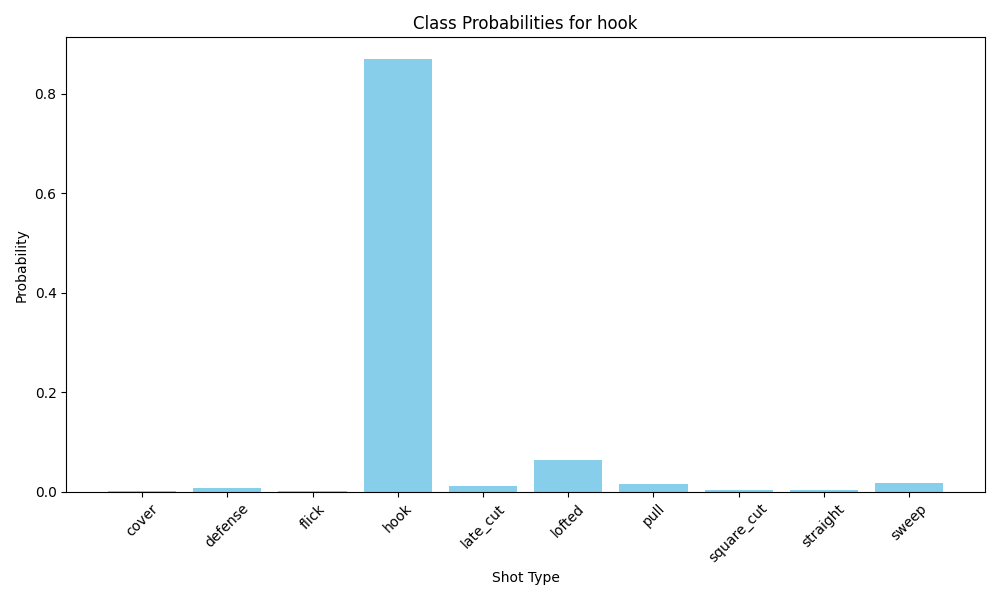

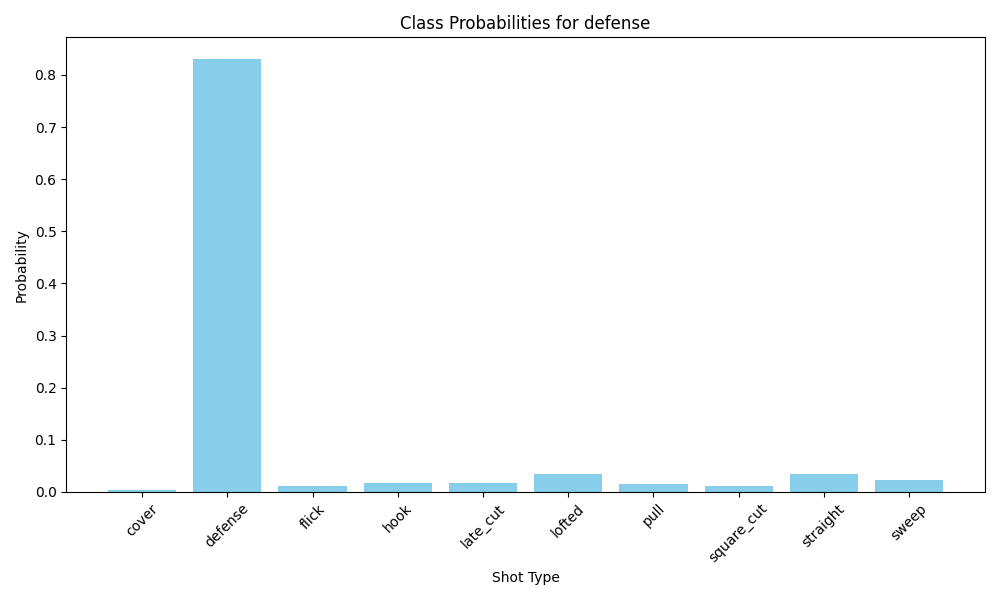

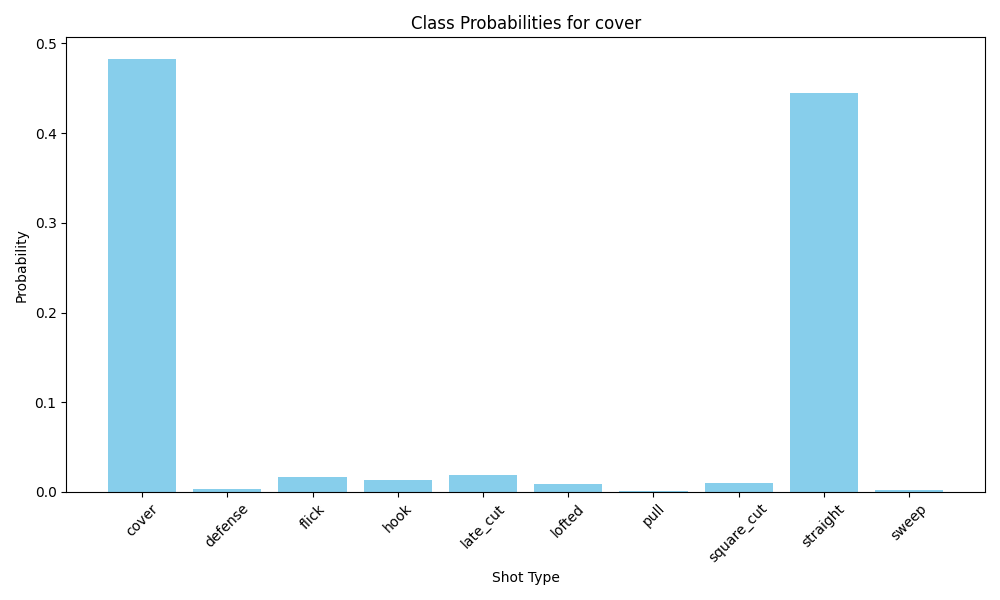

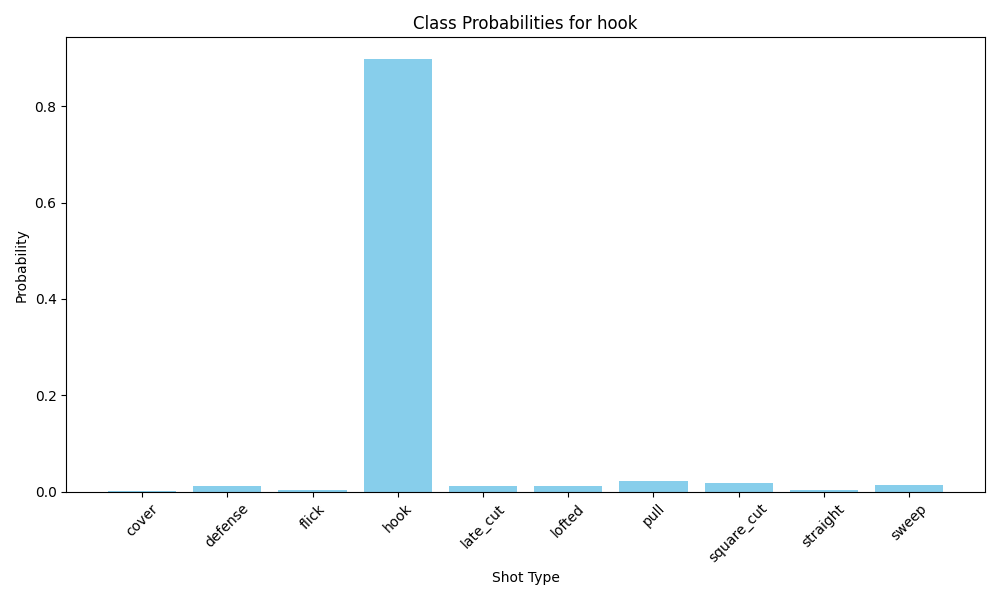

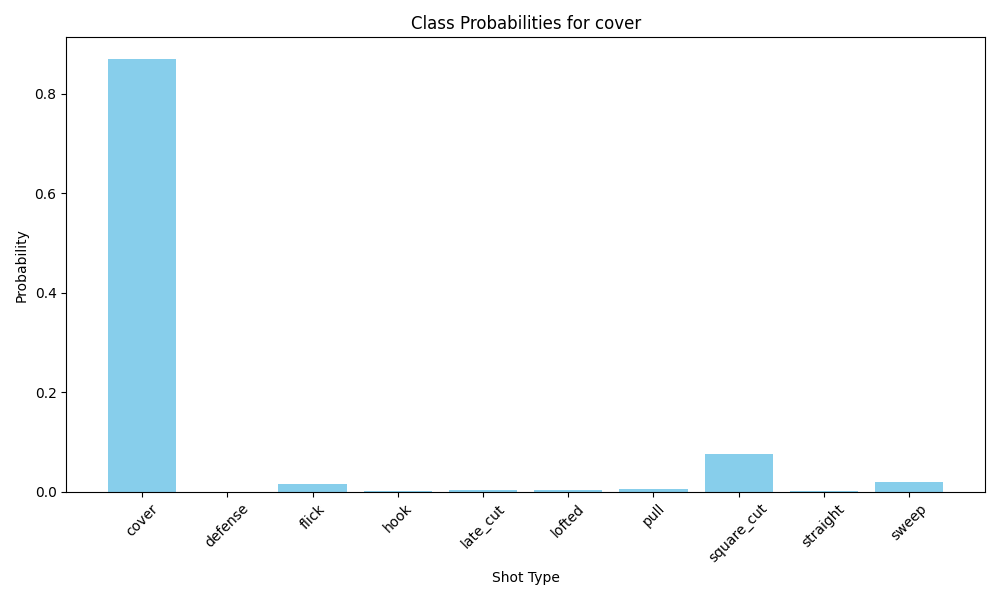

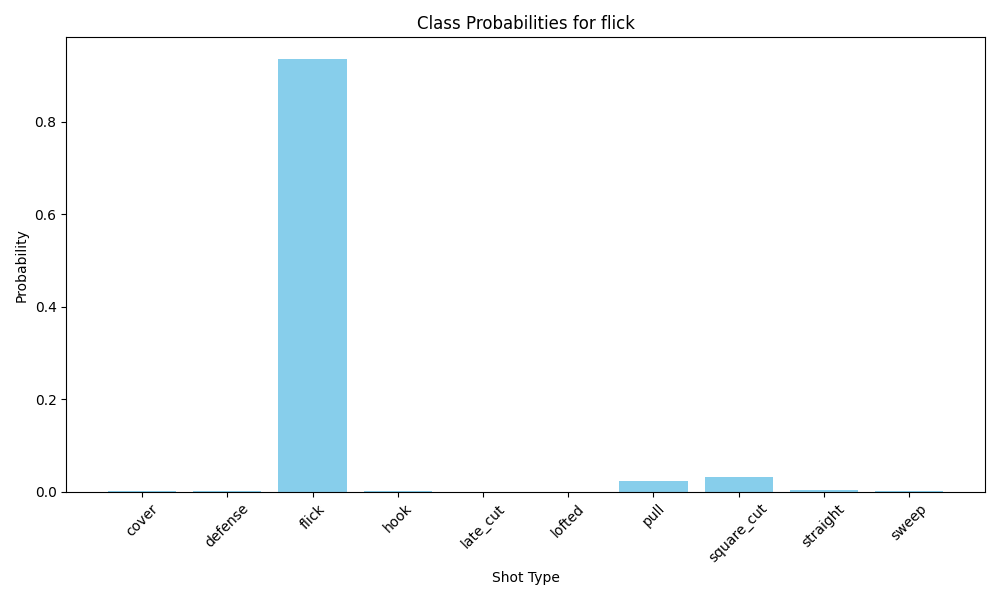

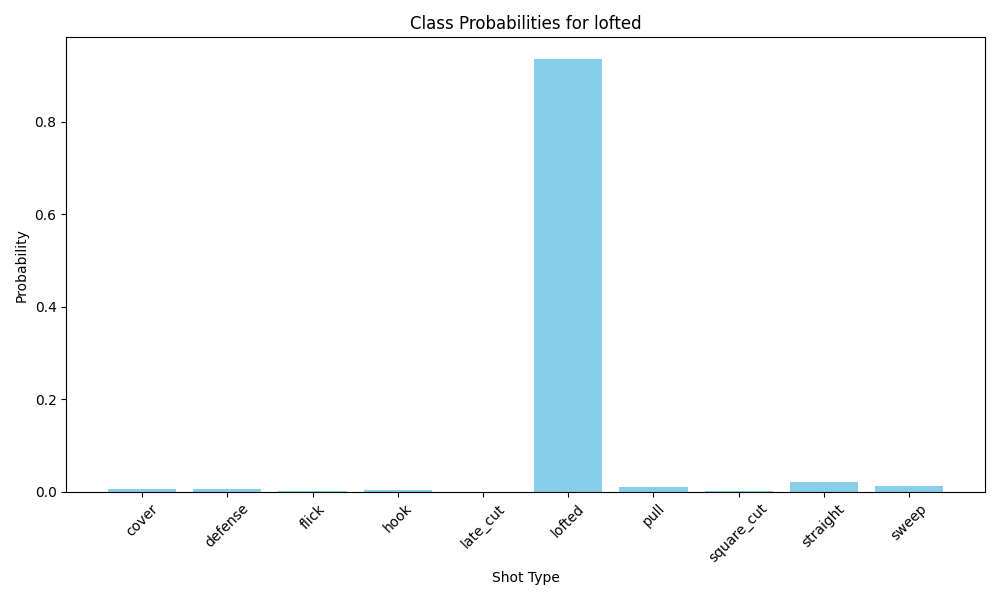

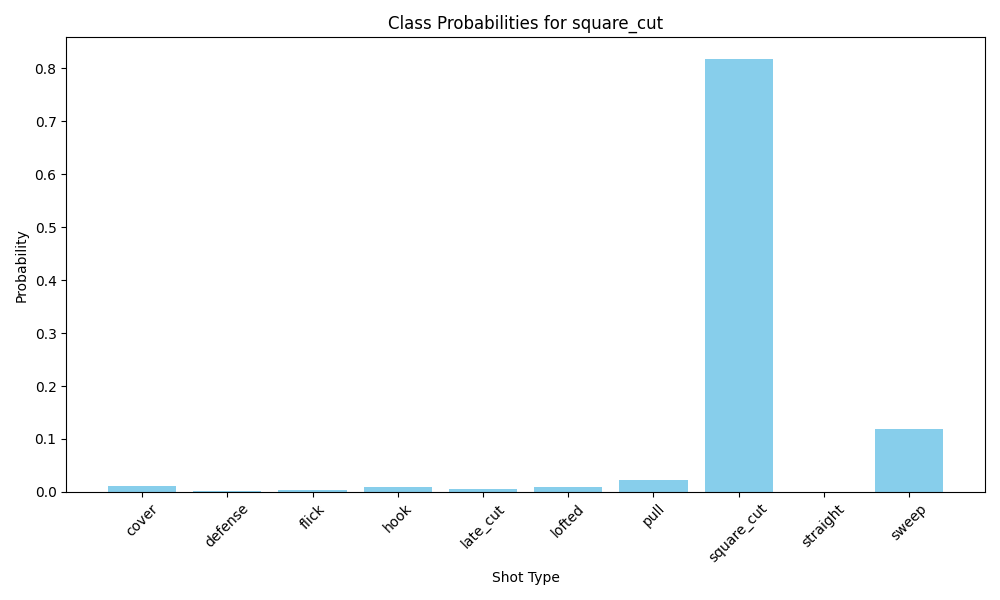

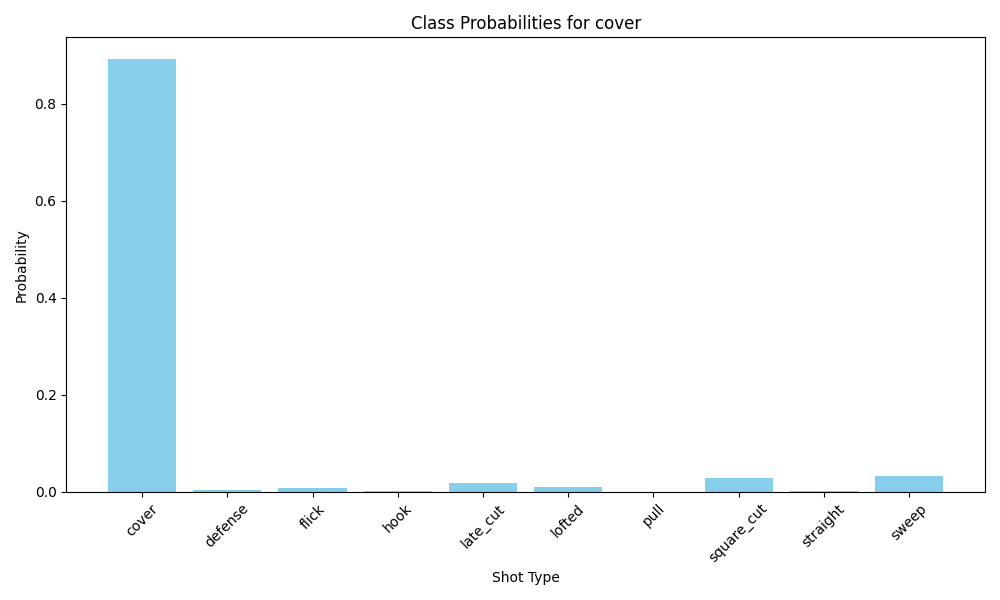

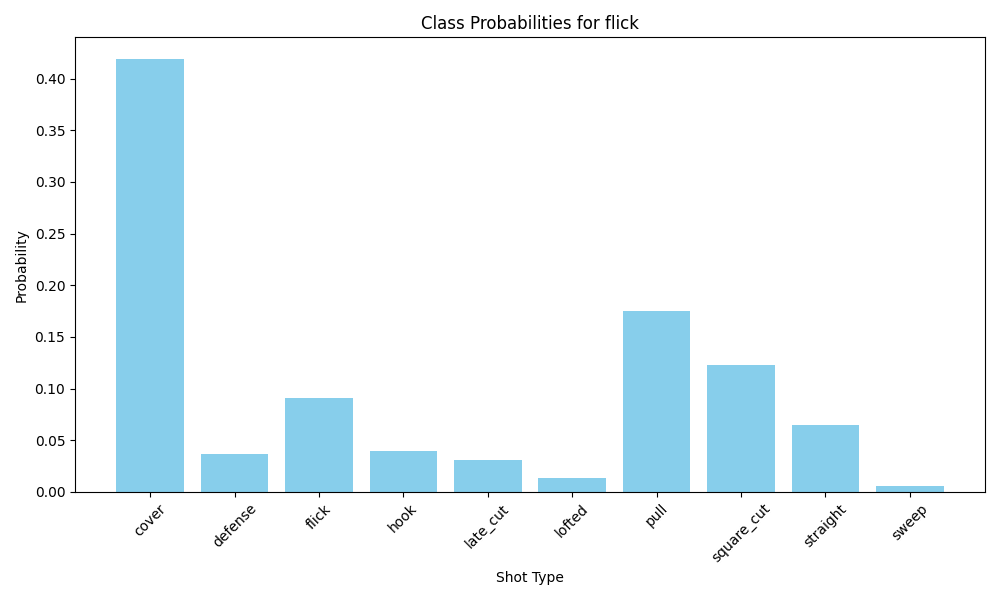

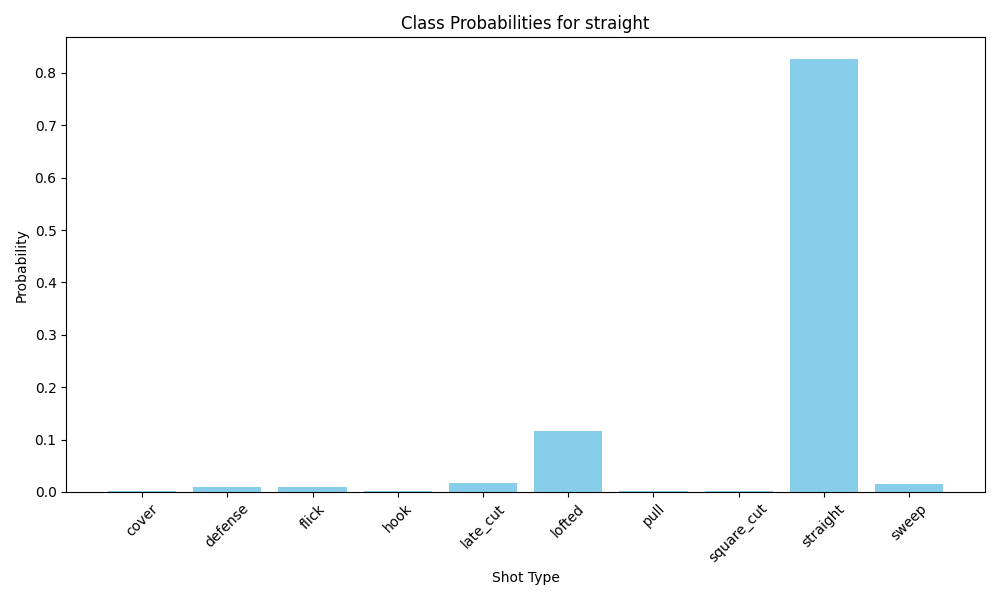

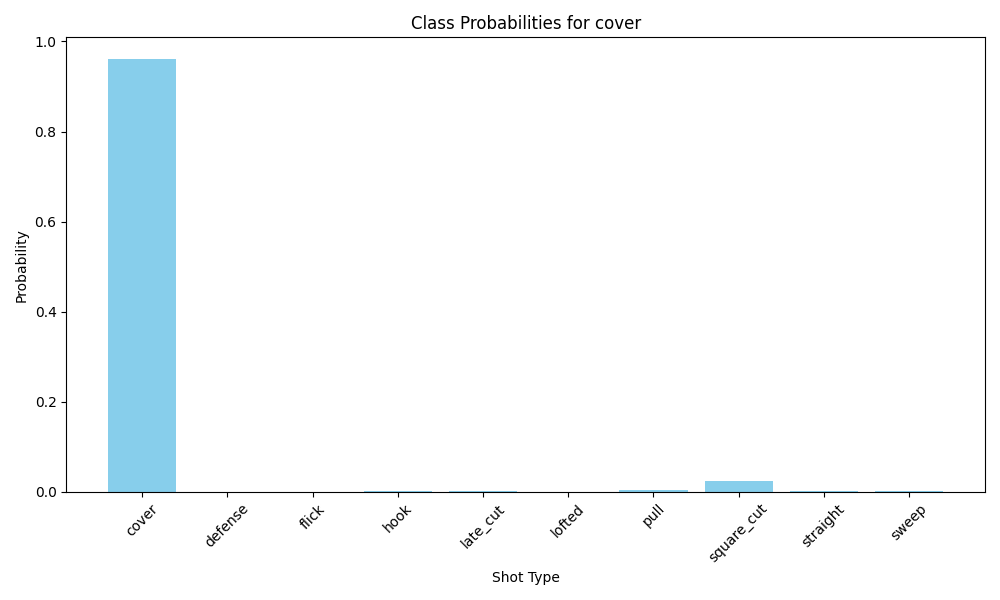

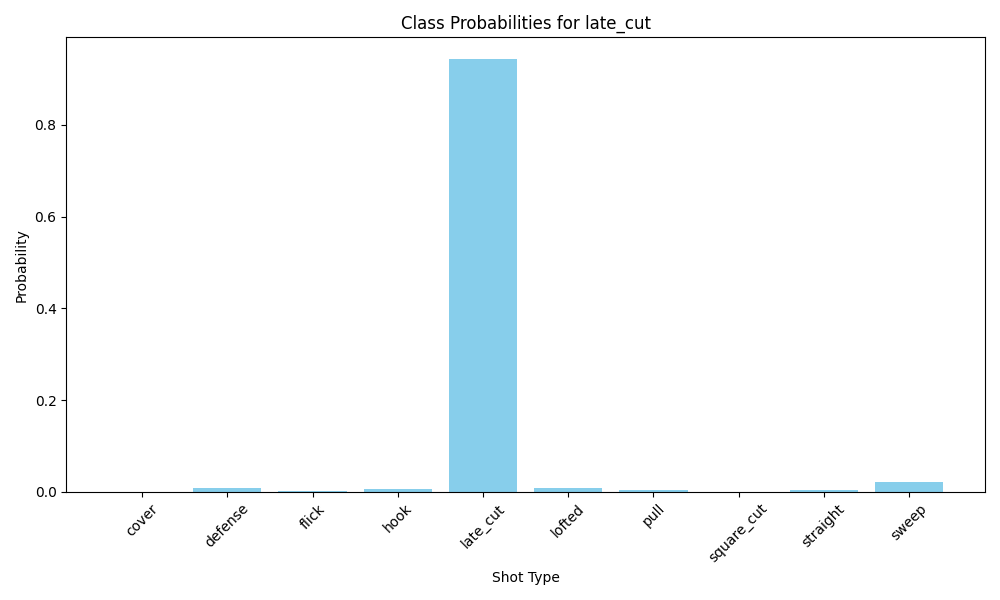

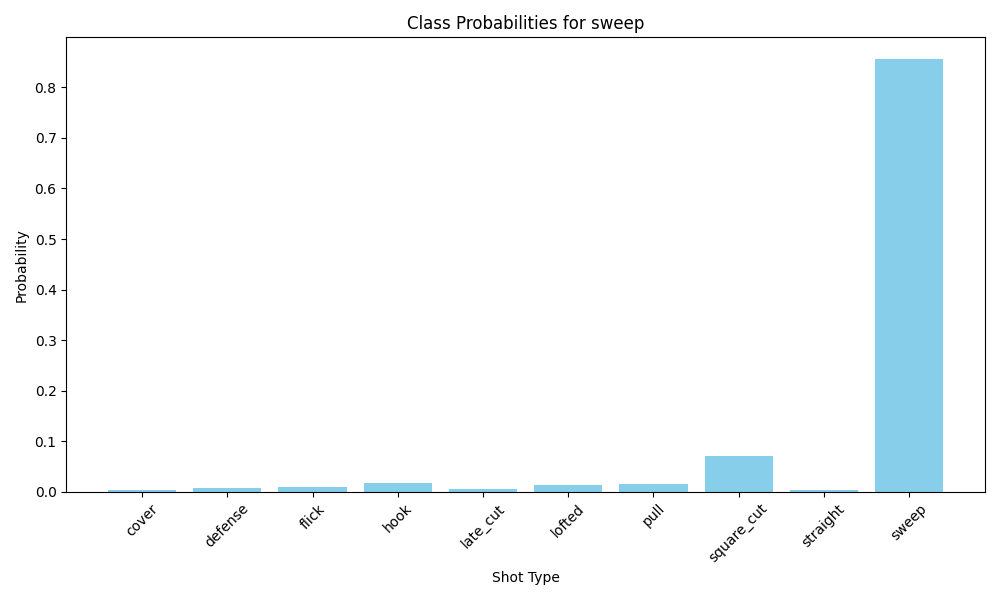

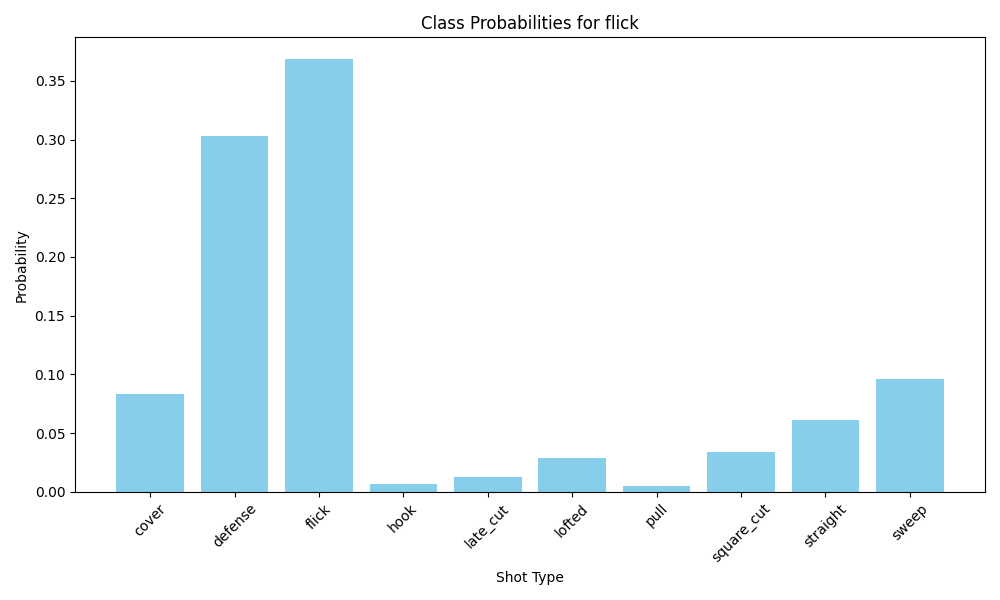

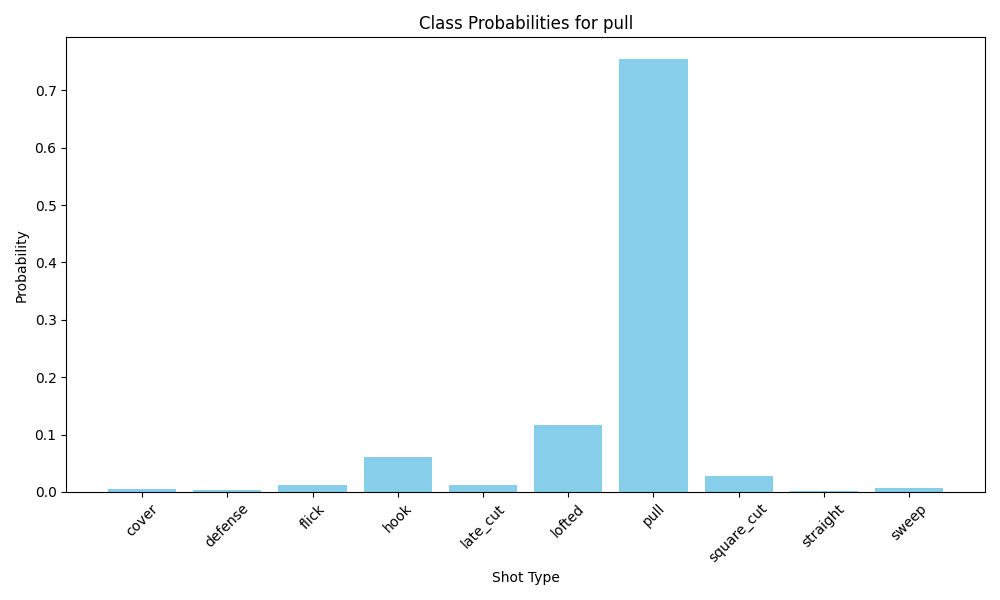

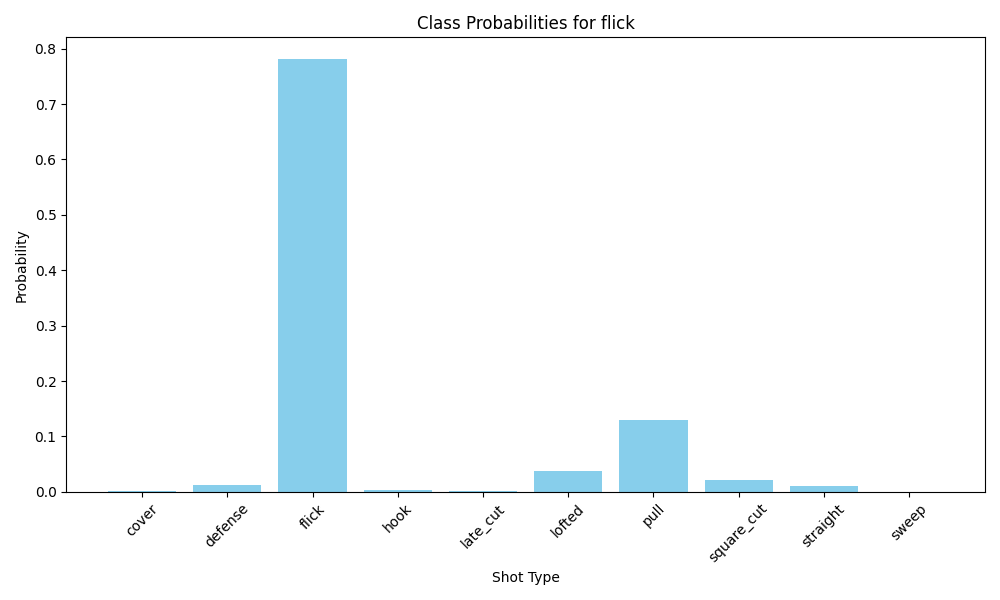

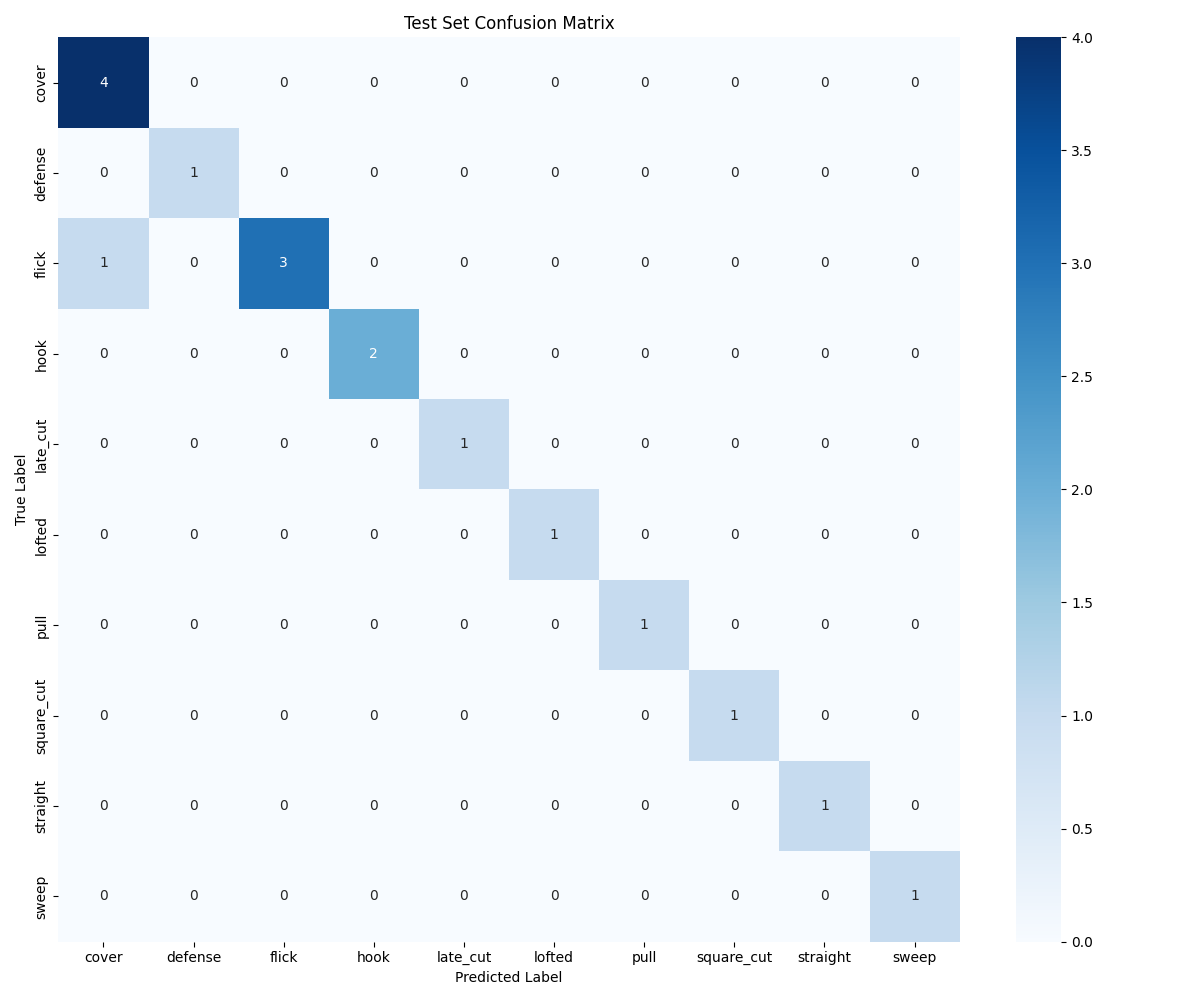


Predictions:
Video: hook_0024.avi, Predicted shot: hook, Confidence: 0.8695, Plot: /kaggle/working/test_plots/probs_hook_0024_avi.png
Video: defense_0136.avi, Predicted shot: defense, Confidence: 0.8307, Plot: /kaggle/working/test_plots/probs_defense_0136_avi.png
Video: cover_0155.avi, Predicted shot: cover, Confidence: 0.4827, Plot: /kaggle/working/test_plots/probs_cover_0155_avi.png
Video: hook_0028.avi, Predicted shot: hook, Confidence: 0.8976, Plot: /kaggle/working/test_plots/probs_hook_0028_avi.png
Video: cover_0080.avi, Predicted shot: cover, Confidence: 0.8701, Plot: /kaggle/working/test_plots/probs_cover_0080_avi.png
Video: flick_0001.avi, Predicted shot: flick, Confidence: 0.9357, Plot: /kaggle/working/test_plots/probs_flick_0001_avi.png
Video: lofted_0196.avi, Predicted shot: lofted, Confidence: 0.9362, Plot: /kaggle/working/test_plots/probs_lofted_0196_avi.png
Video: square_cut_0068.avi, Predicted shot: square_cut, Confidence: 0.8178, Plot: /kaggle/working/test_plots/probs_

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
import logging
import os
import zipfile
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from IPython.display import Image, display

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants
FRAME_HEIGHT = 224
FRAME_WIDTH = 224
NUM_FRAMES = 40
BATCH_SIZE = 16
CLASS_LABELS = ['cover', 'defense', 'flick', 'hook', 'late_cut', 
                'lofted', 'pull', 'square_cut', 'straight', 'sweep']

# Image transformation for frame extraction
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((FRAME_HEIGHT, FRAME_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# TestVisualizer class
class TestVisualizer:
    def __init__(self, save_dir='/kaggle/working/test_plots'):
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        self.class_names = ['cover', 'defense', 'flick', 'hook', 'late_cut', 
                           'lofted', 'pull', 'square_cut', 'straight', 'sweep']
    
    def plot_probabilities(self, video_name, probs):
        # Infer shot type from video name
        shot_type = None
        video_name_lower = video_name.lower()
        for label in self.class_names:
            if label in video_name_lower:
                shot_type = label
                break
        if shot_type is None:
            shot_type = "Unknown"
        
        plt.figure(figsize=(10, 6))
        plt.bar(self.class_names, probs, color='skyblue')
        plt.xlabel('Shot Type')
        plt.ylabel('Probability')
        plt.title(f'Class Probabilities for {shot_type}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        safe_name = video_name.replace('/', '_').replace('.', '_')
        plot_path = os.path.join(self.save_dir, f'probs_{safe_name}.png')
        plt.savefig(plot_path)
        plt.close()
        return plot_path
    
    def plot_confusion_matrix(self, true_labels, pred_labels):
        cm = confusion_matrix(true_labels, pred_labels)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.class_names, yticklabels=self.class_names)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Test Set Confusion Matrix')
        plt.tight_layout()
        plot_path = os.path.join(self.save_dir, 'test_confusion_matrix.png')
        plt.savefig(plot_path)
        plt.close()
        return plot_path

# Define the CricketShotClassifier
class CricketShotClassifier(nn.Module):
    def __init__(self, input_size=2048, hidden_size=256, num_layers=2, num_classes=10, dropout=0.3):
        super(CricketShotClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, 
                           bidirectional=True,
                           dropout=dropout if num_layers > 1 else 0)
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, 128),  # *2 for bidirectional
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        self.fc = nn.Sequential(
            nn.BatchNorm1d(hidden_size * 2),  # *2 for bidirectional
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x, seq_lens):
        # Sort by sequence length for packed sequence
        sort_idx = torch.argsort(seq_lens, descending=True)
        x_sorted = x[sort_idx]
        seq_lens_sorted = seq_lens[sort_idx]
        
        # Pack, run LSTM, and unpack
        packed_x = pack_padded_sequence(x_sorted, seq_lens_sorted.cpu(), batch_first=True, enforce_sorted=True)
        packed_out, (hidden, _) = self.lstm(packed_x)
        output, _ = pad_packed_sequence(packed_out, batch_first=True)
        
        # Apply attention
        batch_size = output.size(0)
        weighted_outputs = []
        
        for i in range(batch_size):
            seq_len = seq_lens_sorted[i]
            attention_score = self.attention(output[i, :seq_len]).squeeze(-1)
            attention_score = torch.softmax(attention_score, dim=0)
            weighted_output = torch.matmul(attention_score.unsqueeze(0), output[i, :seq_len])
            weighted_outputs.append(weighted_output)
        
        # Concatenate outputs
        out = torch.cat(weighted_outputs, dim=0)
        
        # Unsort
        unsort_idx = torch.argsort(sort_idx)
        out = out[unsort_idx]
        
        # Final classification
        out = self.fc(out)
        return out

def extract_frames(video_path, num_frames=NUM_FRAMES):
    """
    Extract frames from a video.
    If the video has fewer frames than num_frames, duplicate the last frame.
    
    Args:
        video_path (str): Path to the video file.
        num_frames (int): Number of frames to extract.
    
    Returns:
        tuple: (frames: Tensor of shape (num_frames, 3, FRAME_HEIGHT, FRAME_WIDTH), 
                sequence_length: Actual number of frames extracted before padding)
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        logging.error(f"Failed to open video: {video_path}")
        raise ValueError(f"Cannot open video: {video_path}")
    
    frames = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if frame_count <= num_frames:
        indices = list(range(frame_count))
    else:
        indices = np.linspace(0, frame_count - 1, num_frames, dtype=int)

    for i in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = transform(frame)
            frames.append(frame)

    cap.release()
    sequence_length = len(frames)

    while len(frames) < num_frames:
        frames.append(frames[-1] if frames else torch.zeros(3, FRAME_HEIGHT, FRAME_WIDTH))

    frames = frames[:num_frames]
    return torch.stack(frames), sequence_length

def extract_features(frames, batch_size=BATCH_SIZE):
    """
    Extract features from frames using a pretrained ResNet50 (without its final layer).
    
    Args:
        frames (Tensor): Tensor of shape (num_frames, 3, FRAME_HEIGHT, FRAME_WIDTH).
        batch_size (int): Batch size for feature extraction.
    
    Returns:
        Tensor: Features of shape (num_frames, 2048).
    """
    feature_extractor = models.resnet50(pretrained=True)
    feature_extractor = torch.nn.Sequential(*list(feature_extractor.children())[:-1])
    feature_extractor.eval().to(device)

    features = []
    with torch.no_grad():
        for i in range(0, len(frames), batch_size):
            batch = frames[i:i+batch_size].to(device)
            batch_features = feature_extractor(batch)
            batch_features = batch_features.squeeze(-1).squeeze(-1)
            features.append(batch_features.cpu())

    return torch.cat(features, dim=0)

def infer_true_label(video_name):
    """
    Infer the true label from the video file name (e.g., 'cover_087.avi' -> 'cover').
    
    Args:
        video_name (str): Name of the video file.
    
    Returns:
        int: Index of the true label in CLASS_LABELS, or None if not found.
    """
    video_name = video_name.lower()
    for idx, label in enumerate(CLASS_LABELS):
        if label in video_name:
            return idx
    logging.warning(f"Could not infer true label for {video_name}")
    return None

def predict_shot(zip_path, model_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Predict the cricket shot type for all .avi videos in a zip file and visualize results.
    
    Args:
        zip_path (str): Path to the zip file containing a videos folder.
        model_path (str): Path to the trained model checkpoint.
        device (str): Device to run the model on ('cuda' or 'cpu').
    
    Returns:
        tuple: (predictions: dict mapping video names to (predicted_class_name, confidence_score),
                plot_paths: dict mapping video names to probability plot paths,
                cm_plot_path: path to confusion matrix plot or None)
    """
    device = torch.device(device)
    
    # Initialize visualizer
    visualizer = TestVisualizer()
    
    # Extract zip file
    extract_dir = '/kaggle/working/videos_extracted'
    os.makedirs(extract_dir, exist_ok=True)
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    
    # Find .avi files
    video_files = []
    for root, _, files in os.walk(extract_dir):
        for file in files:
            if file.endswith('.avi'):
                video_files.append(os.path.join(root, file))
    
    if not video_files:
        logging.error("No .avi files found in the zip.")
        raise ValueError("No .avi files found in the zip.")
    
    logging.info(f"Found {len(video_files)} .avi videos for prediction.")
    
    # Load the model
    model = CricketShotClassifier(input_size=2048, hidden_size=256, num_layers=2, 
                                 num_classes=len(CLASS_LABELS), dropout=0.3)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    # Predict shot types and collect labels for confusion matrix
    predictions = {}
    plot_paths = {}
    true_labels = []
    pred_labels = []
    
    for video_path in video_files:
        video_name = os.path.basename(video_path)
        try:
            # Extract frames
            frames, seq_len = extract_frames(video_path)
            
            # Extract features
            features = extract_features(frames)
            
            # Prepare input for model
            features = features.unsqueeze(0)  # Add batch dimension: (1, NUM_FRAMES, 2048)
            seq_len = torch.tensor([seq_len], dtype=torch.long).to(device)  # Sequence length as tensor
            
            # Make prediction
            with torch.no_grad():
                features = features.to(device)
                output = model(features, seq_len)
                probabilities = torch.softmax(output, dim=1)
                confidence, predicted_idx = torch.max(probabilities, dim=1)
                
                predicted_class = CLASS_LABELS[predicted_idx.item()]
                confidence_score = confidence.item()
                probs = probabilities.squeeze().cpu().numpy()
            
            # Store prediction
            predictions[video_name] = (predicted_class, confidence_score)
            
            # Plot probabilities and display
            plot_path = visualizer.plot_probabilities(video_name, probs)
            plot_paths[video_name] = plot_path
            display(Image(filename=plot_path))
            
            # Infer true label for confusion matrix
            true_label_idx = infer_true_label(video_name)
            if true_label_idx is not None:
                true_labels.append(true_label_idx)
                pred_labels.append(predicted_idx.item())
            
            logging.info(f"Video: {video_name}, Predicted shot: {predicted_class}, Confidence: {confidence_score:.4f}, Plot: {plot_path}")
        
        except Exception as e:
            predictions[video_name] = (f"Error: {str(e)}", 0.0)
            plot_paths[video_name] = None
            logging.error(f"Failed to process {video_path}: {str(e)}")
    
    # Plot confusion matrix if true labels are available
    cm_plot_path = None
    if true_labels:
        cm_plot_path = visualizer.plot_confusion_matrix(true_labels, pred_labels)
        logging.info(f"Confusion matrix saved at: {cm_plot_path}")
        display(Image(filename=cm_plot_path))
    
    return predictions, plot_paths, cm_plot_path

# Example usage
if __name__ == "__main__":
    # Zip file path (downloaded from Google Drive)
    zip_path = "/kaggle/working/videos.zip"
    model_path = "final_model.pth"
    
    try:
        # Download zip file from Google Drive
        import gdown
        gdown.download(id="1dQtjVf_T0gH8SXjXGVItyRTYGgXtAU-t", output=zip_path, quiet=False)
        
        # Predict shot types and visualize
        predictions, plot_paths, cm_plot_path = predict_shot(zip_path, model_path)
        
        # Print predictions
        print("\nPredictions:")
        for video_name, (shot_type, confidence) in predictions.items():
            plot_path = plot_paths.get(video_name, "No plot")
            if shot_type.startswith("Error"):
                print(f"Video: {video_name}, {shot_type}, Plot: {plot_path}")
            else:
                print(f"Video: {video_name}, Predicted shot: {shot_type}, Confidence: {confidence:.4f}, Plot: {plot_path}")
        
        if cm_plot_path:
            print(f"Confusion matrix: {cm_plot_path}")
                
    except Exception as e:
        print(f"Error during prediction: {str(e)}")